In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
%matplotlib inline

In [8]:
class PreProcessing:
    
    def __init__(self, X_scaler=None, nbins=32, 
                 orient=8, pix_per_cell=8, cell_per_block=2, 
                 conv='RGB2YCrCb', size=(32,32), window_size=64, cells_per_step=2):
        self.conv = conv
        self.size = size
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.nbins = nbins
        self.X_scaler = X_scaler
        self.window_size = window_size
        self.cells_per_step = cells_per_step
        
        
    def set_image(self, image_file):
        image = mpimg.imread(image_file)
        if image_file[-3:].lower() == 'jpg':
            image = image.astype(np.float32)/255
        self.draw_img = image
        if self.conv != None:
            self.image = self.convert_color(image, self.conv)
        else:
            self.image = image
        self.ch1 = self.image[:,:,0]
        self.ch2 = self.image[:,:,1]
        self.ch3 = self.image[:,:,2]
        
        
    def convert_color(self, img, conv='RGB2YCrCb'):
        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if conv == 'BGR2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        if conv == 'RGB2LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        
        
    def get_bin_spatial(self, image=None):
        if image == None:
            ch1 = self.ch1
            ch2 = self.ch2
            ch3 = self.ch3
        else:
            ch1 = image[:,:,0]
            ch2 = image[:,:,1]
            ch3 = image[:,:,2]
        color1 = cv2.resize(ch1, self.size).ravel()
        color2 = cv2.resize(ch2, self.size).ravel()
        color3 = cv2.resize(ch3, self.size).ravel()
        return np.hstack((color1, color2, color3))
                
        
    def get_color_hist(self, image=None):    #bins_range=(0, 256)
        if image == None:
            ch1 = self.ch1
            ch2 = self.ch2
            ch3 = self.ch3
        else:
            ch1 = image[:,:,0]
            ch2 = image[:,:,1]
            ch3 = image[:,:,2]
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(ch1, bins=self.nbins)
        channel2_hist = np.histogram(ch2, bins=self.nbins)
        channel3_hist = np.histogram(ch3, bins=self.nbins)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    
    def get_hog_features(self, image, vis=False, feature_vec=True):
        if vis == True:
            features, hog_image = hog(image, orientations=self.orient, 
                                      pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                      cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        else:   
            features = hog(image, orientations=self.orient, 
                           pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                           cells_per_block=(self.cell_per_block, self.cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features 
        
        
    def get_all_hog_features(self, vis=False, feature_vec=True):
        if vis == True:            
            features_1, hog_image_1 = self.get_hog_features(self.ch1, vis, feature_vec)
            features_2, hog_image_2 = self.get_hog_features(self.ch2, vis, feature_vec)
            features_3, hog_image_3 = self.get_hog_features(self.ch3, vis, feature_vec)
            return np.hstack((features_1, features_2, features_3)), np.array([hog_image_1, hog_image_2, hog_image_3])
        else:      
            features_1 = self.get_hog_features(self.ch1, vis, feature_vec)
            features_2 = self.get_hog_features(self.ch2, vis, feature_vec)
            features_3 = self.get_hog_features(self.ch3, vis, feature_vec)
            self.hog = np.array([features_1, features_2, features_3])
            return np.hstack((features_1, features_2, features_3))
        
        
    def get_features_for_image(self, vis=False, feature_vec=True):
        hog_features = self.get_all_hog_features(vis, feature_vec)
        spatial_features = self.get_bin_spatial()
        hist_features = self.get_color_hist()
        
        if self.X_scaler == None:
            return np.hstack((spatial_features, hist_features, hog_features))
        else:
            return X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))) 
        
        
    def create_windows(self, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = self.image.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = self.image.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        self.window_size = xy_window[0]
        self.windows = window_list
        
        
    def get_features_for_window(self, vis=False, feature_vec=True):
        hog_features = self.get_all_hog_features(vis, feature_vec)
        spatial_features = self.get_bin_spatial()
        hist_features = self.get_color_hist()
        
        if self.X_scaler == None:
            return np.hstack((spatial_features, hist_features, hog_features))
        else:
            return X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))) 
        
    
    def set_classifier(self, clf):
        self.clf = clf
    
    
    def find_cars(self, ystart, ystop, scale):
        #scale image
        img_tosearch = self.image[ystart:ystop,:,:]
        imshape = img_tosearch.shape
        ctrans_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        #Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // self.pix_per_cell)-1
        nyblocks = (ctrans_tosearch.shape[0] // self.pix_per_cell)-1 
        nblocks_per_window = (self.window_size // self.pix_per_cell)-1 
        nxsteps = (nxblocks - nblocks_per_window) // self.cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // self.cells_per_step

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*self.cells_per_step
                xpos = xb*self.cells_per_step
                # Extract HOG for this patch
                hog1 = self.get_hog_features(ctrans_tosearch[:,:,0], feature_vec=False)
                hog2 = self.get_hog_features(ctrans_tosearch[:,:,1], feature_vec=False)
                hog3 = self.get_hog_features(ctrans_tosearch[:,:,2], feature_vec=False)
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+self.window_size, xleft:xleft+self.window_size], (64,64))

                # Get color features
                spatial_features = self.get_bin_spatial(subimg)
                hist_features = self.get_color_hist(subimg)

                # Scale features and make a prediction
                all_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
                test_features = X_scaler.transform(all_features)
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = self.clf.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(self.window_size*scale)
                    cv2.rectangle(self.draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
        
        
def get_images():
    car_images = glob.glob("./data/vehicles/**/*.png", recursive=True)
    non_car_images = glob.glob("./data/non-vehicles/**/*.png", recursive=True)
    return car_images, non_car_images

def get_train_test_data(car, non_car, preprocessor):
    car_features = []
    notcar_features = []
    print("Total Images: {}".format(len(car) + len(non_car)))
    i = 0
    for c in car:
        preprocessor.set_image(c)
        car_features.append(preprocessor.get_features_for_image())
        i=i+1
    for nc in non_car:
        preprocessor.set_image(nc)
        notcar_features.append(preprocessor.get_features_for_image())
        i=i+1

    X = np.vstack((car_features, notcar_features)).astype(np.float64)     
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test, X_scaler

## Train Model

In [3]:
car, noncar = get_images()
p = PreProcessing()
X_train, X_test, y_train, y_test, X_scaler = get_train_test_data(car, noncar, p)

Total Images: 17760


In [4]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9904


In [20]:
p = PreProcessing(X_scaler=X_scaler, window_size=64)
p.set_image("./test_images/test1.jpg")
p.set_classifier(svc)
#p.set_image("./data/vehicles/GTI_Far/image0000.png")

In [21]:
p.find_cars(400, 700, 2)

36
5


/Users/tylerfolkman/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/tylerfolkman/anaconda/envs/carnd/lib/python3.5/site-packages/ipykernel/__main__.py:56: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


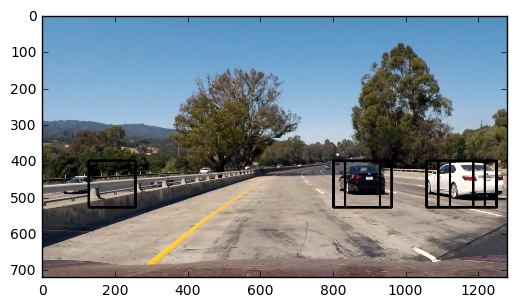

In [22]:
plt.imshow(p.draw_img)

In [ ]:
f[0].reshape(720,1280)

In [ ]:
p.image.shape

In [ ]:
window

In [ ]:
nblocks_per_window = (64//8)-1
hog_feat1 = f[window[0][1]:window[0][1]+nblocks_per_window, window[0][0]:window[0][0]+nblocks_per_window].ravel()

In [ ]:
hog_feat1.shape

In [ ]:
x=mpimg.imread("./test_images/test1.jpg")

In [ ]:
plt.imshow(x)

In [ ]:
x.shape